# INFO 2950 Project Phase II

## Research Question

Our research question/goal is to successfully measuring a NBA player's ability to induce and convert offensive opportunities for himself, as well as leading teammates to those opportunities. In other words, we are attempting to measure how good a player is at creating and efficiently making shots for himself, and at making plays that lead to points for his teammates.

## Data Cleaning

In [217]:
# Load Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

In [2]:
# Concatenating PBP scoring files
pbp_sc_files = []
for i in np.arange(1,22):
    name = 'pbpstats_export-{}.csv'.format(i)
    file = pd.read_csv(name)
    file['Season'] = 2022-i
    pbp_sc_files.append(file)
pbp_sc = pd.concat(pbp_sc_files)

# Final PBP scoring csv
pbp_sc.to_csv('pbp_sc.csv')

In [3]:
# Concatenating PBP assist files
pbp_as_files = []
for i in np.arange(-42,-21):
    name = 'pbpstats_export-{}.csv'.format(-i)
    file = pd.read_csv(name)
    file['Season'] = 2000-21-i
    pbp_as_files.append(file)    
pbp_as = pd.concat(pbp_as_files)

# Final PBP assist csv
pbp_as.to_csv('pbp_as.csv')

In the above two cells, we combined the individual season PBP scoring and assist, respectively, data CSVs into a single CSV containing the data for every season.

In [88]:
# Reading in csv files
pbp_score = pd.read_csv('pbp_sc.csv')
pbp_assist = pd.read_csv('pbp_as.csv')
nba_pos = pd.read_csv('NBA Players.csv')
seasonStats1950to2017 = pd.read_csv('Season_Stats_1950to2017.csv')
seasonStats2017to2019 = pd.read_csv('Season_Stats_2017to2019.csv')
seasonStats2019to2021 = pd.read_csv('Season_Stats_2019to2021.csv')

Prior to reading in the 2017-2019 and 2019-2021 season data, we had to copy and paste the individual, "raw" data in separate excel sheets into a single sheet for each of those time periods. This is because when data is downloaded from Stahead as a CSV, only 100 entries can be downloaded at a time.

In [89]:
# Drop data from before 2000-2001 season
seasonStats2000to2017 = seasonStats1950to2017[seasonStats1950to2017['Year'] >= 2001]
# Reset index to default so idx doesn't start at some random value
seasonStats2000to2017 = seasonStats2000to2017.reset_index()
# Drop some irrelevant columns
seasonStats2000to2017 = seasonStats2000to2017.drop(['index', 'Unnamed: 0', 'blanl', 'blank2', 'Pos'], axis = 1)
# Change the datatype of year (= season) from float64 to int
seasonStats2000to2017 = seasonStats2000to2017.astype({'Year': int})

Due to the PBP data only going back to the 2000-2001 season, we are limiting the scope of our analysis to just the last 20 NBA seasons. So, in the above cell, we dropped all data from before the 2000-2001 season in our Basketball Reference DataFrame. Additionally, we dropped some unnecessary columns. Finally, we changed the type of the 'Year' values from float64 to int, which is the true type of a year.

In [90]:
# Add missing columns into 2019 to 2021 data
seasonStats2019to2021['FG%'] = round(seasonStats2019to2021['FG']/seasonStats2019to2021['FGA'], 3)
seasonStats2019to2021['2P%'] = round(seasonStats2019to2021['2P']/seasonStats2019to2021['2PA'],3)
seasonStats2019to2021['3P%'] = round(seasonStats2019to2021['3P']/seasonStats2019to2021['3PA'],3)
seasonStats2019to2021['FT%'] = round(seasonStats2019to2021['FT']/seasonStats2019to2021['FTA'],3)
seasonStats2019to2021['eFG%'] = round(((seasonStats2019to2021['FG'] + (0.5*seasonStats2019to2021['3P']))/
                                 seasonStats2019to2021['FGA']),3)
seasonStats2019to2021['TS%'] = round(((seasonStats2019to2021['PTS'])/
                                (2*(seasonStats2019to2021['FGA'])+(0.44*seasonStats2019to2021['FTA']))),3)

In the above cell, we added some columns into our DataFrame containing the 2019-2021 Stathead data that were missing. These columns were present in our DataFrames containing the 2000-2017 and 2017-2019 data.

In [91]:
# Drop extraneous columns from 2017 to 2019 and 2019 to 2021 data
seasonStats2017to2019 = seasonStats2017to2019.drop(['ORtg','DRtg', 'Lg'], axis = 1)
seasonStats2019to2021 = seasonStats2019to2021.drop(['ORtg','DRtg', 'Lg'], axis = 1)

In the above cell, we dropped some unnecessary columns present in the 2017-2019 and 2019-2021 Stathead DataFrames.

In [92]:
# Drop all rows with NaNs from 2017 to 2019 data.
seasonStats2017to2019 = seasonStats2017to2019.dropna(how = 'all')

Here, we had to drop some trailing rows of NaNs that were present at the end of the 2017-2019 Stathead DataFrame.

In [93]:
# Renaming and reordering columns across the 3 dfs
seasonStats2000to2017 = seasonStats2000to2017.rename(columns = {'Year': 'Season'})
cols = list(seasonStats2000to2017.columns)
seasonStats2017to2019 = seasonStats2017to2019[cols]
seasonStats2019to2021 = seasonStats2019to2021[cols]

In the above cell, we had to rename the 'Year' column in the 2000-2017 Dataframe to match the corresponding column title in the 2017-2019 and 2019-2021 DataFrames. Additionally, we reordered the columns in the 2017-2019 and 2019-2021 DataFrames to match the other DataFrame. This will ease the process of combining the three DataFrames.

In [94]:
# Converting Season column values to be same across the 3 dfs
for i in np.arange(len(seasonStats2017to2019)):
    seasonStats2017to2019.loc[i,'Season'] = int(seasonStats2017to2019.loc[i,'Season'][-2:])+2000

for i in np.arange(len(seasonStats2019to2021)):
    seasonStats2019to2021.loc[i,'Season'] = int(seasonStats2019to2021.loc[i,'Season'][-2:])+2000

In the above cell, we converted the 'Season' column values in two of the three DataFrames so that they would match across all three. Once again, this will simplify the process of combining the three DataFrames.

In [95]:
# Combining the 3 df into a single Stathead df
seasonStats = [seasonStats2000to2017,seasonStats2017to2019,seasonStats2019to2021]
nba = pd.concat(seasonStats)

Here, we actually perform the concatenation, creating a single DataFrame corresponding to all of our Stathead/Basketball Reference data.

In [96]:
# Cleaning Team Names
nba = nba.rename(columns = {'tm': 'team'})
nba.columns = [header.lower() for header in nba.columns]

# Changing team abbreviations to match modern versions
nba = nba.replace({'team':{
    'CHO': 'CHA',
    'CHH': 'CHA',
    'BRK': 'BKN',
    'NJN': 'BKN',
    'VAN': 'MEM',
    'PHO': 'PHX',
    'NOH': 'NOP',
    'NOK': 'NOP',
    'SEA': 'OKC',
}})

In the above cell, we changed team abbreivations to match modern versions. Thus, there will be 31 values corresponding to team, representing each of the 30 NBA franchise present in our dataset (no defunct teams are apart of our dataset) and a 31st value 'TOT', which means the player played for multiple teams that season.

In [97]:
# Addressing player names with accents
names = nba.player.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
nba.player = names

In the above cell, we standardized player names, particularly those with accents, which were handled differently by the differently by Stathead and PBP.

In [98]:
# Removing duplicate rows with players playing for multiple teams in one season
# Keeping row of aggregate stats for that player for that season
nba = nba.drop_duplicates(subset = ['player','season'])

Players who switched teams in the middle of a season had entires in our Stathead/Basketball Reference DataFrame for both their overall season numbers, and their splits for each team they played for. This cell drops the extra entries, which correspond to their team splits, and keeps just their season-long numbers.

In [99]:
# 70% mins cutoff
mins70 = list(nba.groupby('season').mp.quantile(q=0.3))
all_bl = [False]*len(nba)
year = 2001
for i in np.arange(len(mins70)):
    bl = np.logical_and(nba.season==year , nba.mp > mins70[i])
    all_bl = np.logical_or(all_bl, bl)
    year += 1

In [100]:
# Assigning final rows of df
nba_filtered = nba.loc[all_bl]

In the above two cells, we remove all players who were not above the 30th percentile in minutes played in a particular season. This is due to a few reasons. The first, and primary, reason is because some of our data was not available for many players whose minutes played placed them below the cutoff. Additionally, per-possession and existing advanced statistics are subject to extreme noise when examined for players with lower amounts of minutes played, as these small sample sizes are not representative of a player’s true ability and are often strongly influenced by external factors.

In [101]:
# Change datatypes of certain columns to match their true type
nba_filtered = nba_filtered.astype({'season': int, 'age': int, 'g': int, 'gs': int, 'mp': int, 'fg': int, 'fga': int,
                                  '3p': int, '3pa': int, '2p': int, '2pa': int, 'ft': int, 'fta': int, 'orb': int,
                                  'drb': int, 'trb': int, 'ast': int, 'stl': int, 'blk': int, 'tov': int, 'pf': int,
                                  'pts': int})
nba_filtered.head()

,season,player,age,tm,g,gs,mp,per,ts%,3par,ftr,orb%,drb%,trb%,ast%,stl%,blk%,tov%,usg%,ows,dws,ws,ws/48,obpm,dbpm,bpm,vorp,fg,fga,fg%,3p,3pa,3p%,2p,2pa,2p%,efg%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts
2,2001,Shareef Abdur-Rahim,24,VAN,81,81,3241,19.1,0.549,0.050,0.415,6.2,19.6,13.0,14.3,1.5,1.6,13.2,24.6,5.6,2.9,8.5,0.126,1.3,0.9,2.2,3.5,604,1280,0.472,12,64,0.188,592,1216,0.487,0.477,443,531,0.834,175,560,735,250,90,77,231,238,1663
4,2001,Courtney Alexander,23,TOT,65,24,1382,11.6,0.484,0.080,0.262,3.5,8.4,5.9,8.0,1.7,0.3,10.5,23.2,0.3,0.5,0.8,0.027,-1.8,-2.5,-4.4,-0.8,239,573,0.417,17,46,0.370,222,527,0.421,0.432,123,150,0.820,42,101,143,62,45,5,75,139,618
7,2001,Ray Allen,25,MIL,82,82,3129,22.9,0.610,0.357,0.299,3.7,11.8,7.8,20.4,2.1,0.5,12.1,24.4,11.5,2.2,13.7,0.211,6.5,-0.9,5.6,6.0,628,1309,0.480,202,467,0.433,426,842,0.506,0.557,348,392,0.888,101,327,428,374,124,20,204,192,1806
9,2001,John Amaechi,30,ORL,82,36,1710,8.7,0.455,0.012,0.471,4.9,12.7,8.7,7.0,0.8,1.2,14.8,21.7,-1.3,1.4,0.0,0.001,-5.1,-1.8,-6.9,-2.1,237,592,0.400,0,7,0.000,237,585,0.405,0.400,176,279,0.631,77,191,268,74,28,29,124,175,650
10,2001,Derek Anderson,26,SAS,82,82,2859,17.1,0.542,0.255,0.405,3.1,10.9,7.2,18.1,2.2,0.3,12.4,21.9,5.6,4.3,9.9,0.166,2.6,1.0,3.6,4.0,413,993,0.416,101,253,0.399,312,740,0.422,0.467,342,402,0.851,75,288,363,301,120,14,165,188,1269


In the above cell, we changed the datatype of certain columns to reflect their true type. When our data was read in, these columns all had the datatype float64, which is nonsensical.

In [102]:
# Drop some irrelevant, unnecessary, and/or redundant columns from PBP data
pbp_score = pbp_score.drop(['Unnamed: 0', 'TeamAbbreviation', 'GamesPlayed', 'Minutes', 'Points','FG2M', 'FG2A',
                            'Fg2Pct', 'FG3M', 'FG3A', 'Fg3Pct', 'FG3APct','EfgPct', 'TsPct','Usage'], axis = 1)
pbp_assist = pbp_assist.drop(['Unnamed: 0', 'TeamAbbreviation', 'GamesPlayed', 'Minutes', 'Assists'], axis = 1)

Here, we dropped columns which were either irrelevant, unnecessary, or redundant from our PBP DataFrames.

In [103]:
# Tidying up columns in PBP data
pbp_score.columns = [header.lower() for header in pbp_score.columns]
pbp_assist.columns = [header.lower() for header in pbp_assist.columns]

In [104]:
# Rename name to player for pbp
pbp_score = pbp_score.rename(columns = {'name' : 'player'})
pbp_assist = pbp_assist.rename(columns = {'name' : 'player'})

# Merge 2 pbp files
pbp = pbp_score.merge(pbp_assist)

In the prior cell, we changed the name of the 'name' column to 'player' in our PBP DataFrames to match the corresponding column name in the Stathead/Basketball Reference DataFrame. Additionally, we merged the two PBP DataFrames to make one PBP DataFrame containing both the scoring and assist data.

In [105]:
# Merge dfs from the 2 different datasets to create single df
nba_1 = nba_filtered.merge(pbp, how = 'inner', on = ['player', 'season'])

Here, we merged our Stathead/Basketball Reference and PBP DataFrames to one, comprehensive DataFrame.

In [106]:
# Adjusting player names of nba player position df
pos_names = nba_pos.player.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
nba_pos.player = pos_names
# Assigning position to corresponding player
nba = nba_1.merge(nba_pos, on = 'player', how = 'left')

Earlier, we removed the column containing player position in our Stathead/Basketball Reference 2000-2017 DataFrame because it was not present in any of the other datasheets we were going to be working with. However, because having the position for each player could enhance our analysis, we added it to our final DataFrame in the above cell.

In [107]:
# Manually adding position of 1 player, Omer Asik, whose position was missing from the csv
omer_i = list(nba.loc[nba.pos.isnull()].index)
nba.loc[omer_i,'pos'] = "C"

Our position DataFrame had one missing value: it did not include the position for Omer Asik. In the above cell, we manually added it in.

In [108]:
nba.columns

Index(['season', 'player', 'age', 'tm', 'g', 'gs', 'mp', 'per', 'ts%', '3par',
       'ftr', 'orb%', 'drb%', 'trb%', 'ast%', 'stl%', 'blk%', 'tov%', 'usg%',
       'ows', 'dws', 'ws', 'ws/48', 'obpm', 'dbpm', 'bpm', 'vorp', 'fg', 'fga',
       'fg%', '3p', '3pa', '3p%', '2p', '2pa', '2p%', 'efg%', 'ft', 'fta',
       'ft%', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts',
       'offposs', 'nonheavefg3pct', 'ftpoints', 'ptsassisted2s',
       'ptsunassisted2s', 'ptsassisted3s', 'ptsunassisted3s', 'assisted2spct',
       'nonputbacksassisted2spct', 'assisted3spct', 'shotqualityavg',
       'ptsputbacks', 'fg2ablocked', 'fg2apctblocked', 'fg3ablocked',
       'fg3apctblocked', 'assistpoints', 'twoptassists', 'threeptassists',
       'atrimassists', 'shortmidrangeassists', 'longmidrangeassists',
       'corner3assists', 'arc3assists', 'pos'],
      dtype='object')

In [110]:
nba.head()

,season,player,age,tm,g,gs,mp,per,ts%,3par,ftr,orb%,drb%,trb%,ast%,stl%,blk%,tov%,usg%,ows,dws,ws,ws/48,obpm,dbpm,bpm,vorp,fg,fga,fg%,3p,3pa,3p%,2p,2pa,2p%,efg%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,offposs,nonheavefg3pct,ftpoints,ptsassisted2s,ptsunassisted2s,ptsassisted3s,ptsunassisted3s,assisted2spct,nonputbacksassisted2spct,assisted3spct,shotqualityavg,ptsputbacks,fg2ablocked,fg2apctblocked,fg3ablocked,fg3apctblocked,assistpoints,twoptassists,threeptassists,atrimassists,shortmidrangeassists,longmidrangeassists,corner3assists,arc3assists,pos
0,2001,Shareef Abdur-Rahim,24,VAN,81,81,3241,19.1,0.549,0.050,0.415,6.2,19.6,13.0,14.3,1.5,1.6,13.2,24.6,5.6,2.9,8.5,0.126,1.3,0.9,2.2,3.5,604,1280,0.472,12,64,0.188,592,1216,0.487,0.477,443,531,0.834,175,560,735,250,90,77,231,238,1663,6247,0.193548,443,796,388,33,3,0.672297,0.727605,0.916667,0.459027,90,150,0.123355,1,0.015625,556,194,56,58,25,111,9,47,F
1,2001,Courtney Alexander,23,TOT,65,24,1382,11.6,0.484,0.080,0.262,3.5,8.4,5.9,8.0,1.7,0.3,10.5,23.2,0.3,0.5,0.8,0.027,-1.8,-2.5,-4.4,-0.8,239,573,0.417,17,46,0.370,222,527,0.421,0.432,123,150,0.820,42,101,143,62,45,5,75,139,618,2693,0.395349,123,258,186,30,21,0.581081,0.600000,0.588235,0.435947,14,35,0.066414,0,0.000000,131,55,7,19,6,30,2,5,G
2,2001,Ray Allen,25,MIL,82,82,3129,22.9,0.610,0.357,0.299,3.7,11.8,7.8,20.4,2.1,0.5,12.1,24.4,11.5,2.2,13.7,0.211,6.5,-0.9,5.6,6.0,628,1309,0.480,202,467,0.433,426,842,0.506,0.557,348,392,0.888,101,327,428,374,124,20,204,192,1806,6071,0.436285,348,372,480,519,87,0.436620,0.452555,0.856436,0.499029,30,52,0.061758,2,0.004283,846,276,98,101,78,97,36,62,G
3,2001,John Amaechi,30,ORL,82,36,1710,8.7,0.455,0.012,0.471,4.9,12.7,8.7,7.0,0.8,1.2,14.8,21.7,-1.3,1.4,0.0,0.001,-5.1,-1.8,-6.9,-2.1,237,592,0.400,0,7,0.000,237,585,0.405,0.400,176,279,0.631,77,191,268,74,28,29,124,175,650,3302,0.000000,176,246,228,0,0,0.518987,0.549107,0.000000,0.468805,26,65,0.111111,0,0.000000,171,51,23,31,6,14,3,20,C
4,2001,Derek Anderson,26,SAS,82,82,2859,17.1,0.542,0.255,0.405,3.1,10.9,7.2,18.1,2.2,0.3,12.4,21.9,5.6,4.3,9.9,0.166,2.6,1.0,3.6,4.0,413,993,0.416,101,253,0.399,312,740,0.422,0.467,342,402,0.851,75,288,363,301,120,14,165,188,1269,5405,0.404000,342,330,294,264,39,0.528846,0.557432,0.871287,0.499851,32,51,0.068919,2,0.007905,674,229,72,115,51,63,33,39,G


## Exploratory Data Analysis

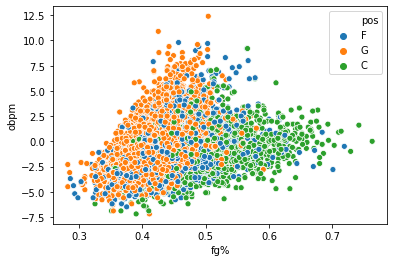

In [30]:
# OBPM - Just getting ideas down, nothing great yet
sns.scatterplot(
    x = nba.loc[:,'fg%'],
    y = nba.loc[:,'obpm'],
    hue = nba.pos
)
plt.show()

In [221]:
def nVarLinRegbyPos(xvar, yvar):
    '''
    xvar = list of length n (where n >= 1) containing column names
    yvar = list of length 1 containing one column name 
    '''
    colors = ['lightskyblue','tab:green','red']
    for i in np.arange(len(nba.pos.unique())):
        position = nba.pos.unique()[i]
        grouped_x = nba.groupby('pos').get_group(position).loc[:,xvar]
        grouped_y = nba.groupby('pos').get_group(position).loc[:,yvar]
        multi_model = LinearRegression()
        multi_model.fit(grouped_x[xvar], grouped_y[yvar])
        r2 = multi_model.score(grouped_x[xvar], grouped_y[yvar])
        print(f'For {position}: R^2 between {xvar} and {yvar}: {r2 : .4f}')
        # Scatterplots
        for j in range(0,len(xvar)):
            fig, ax = plt.subplots()
            ax.scatter(
                grouped_x[xvar[j]],
                multi_model.predict(grouped_x), # plot predicted vs. the column corresponding to the jth entry in xvar
                color = colors[i],
                alpha = 0.3)
            ax.set_xlabel(xvar)
            ax.set_ylabel(yvar)
            ax.set_title(position)
            plt.tight_layout()
            plt.show()

For F: R^2 between ['assistpoints', 'ptsunassisted2s'] and ['obpm']:  0.4477


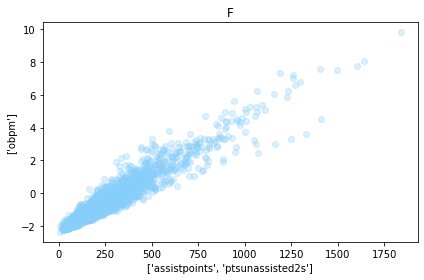

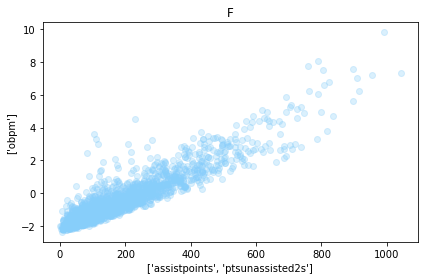

For G: R^2 between ['assistpoints', 'ptsunassisted2s'] and ['obpm']:  0.4377


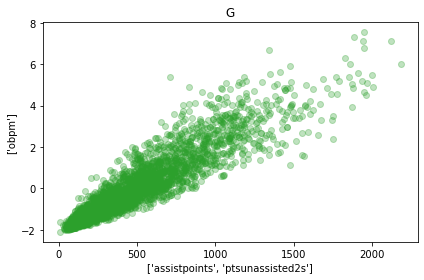

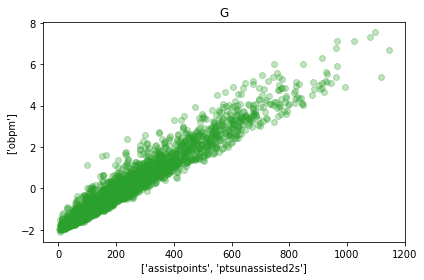

For C: R^2 between ['assistpoints', 'ptsunassisted2s'] and ['obpm']:  0.4211


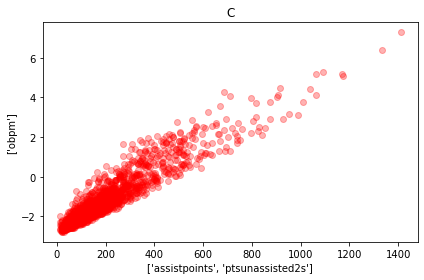

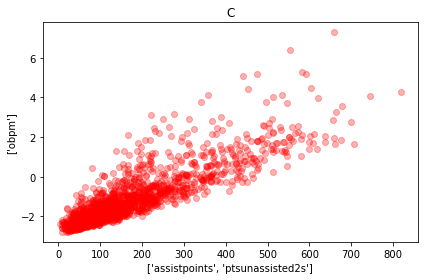

In [222]:
nVarLinRegbyPos(['assistpoints', 'ptsunassisted2s'], ['obpm'])

For F: R^2 between ['assistpoints'] and ['obpm']:  0.4067


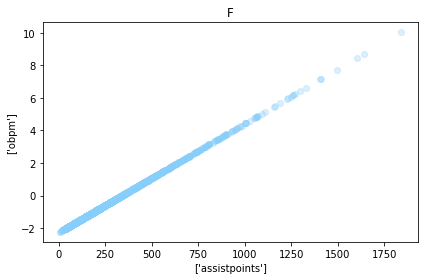

For G: R^2 between ['assistpoints'] and ['obpm']:  0.3675


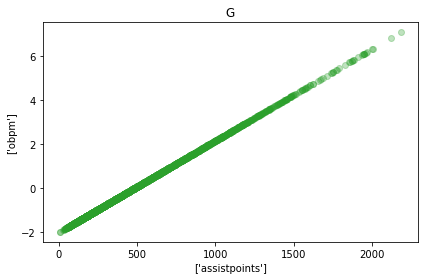

For C: R^2 between ['assistpoints'] and ['obpm']:  0.3708


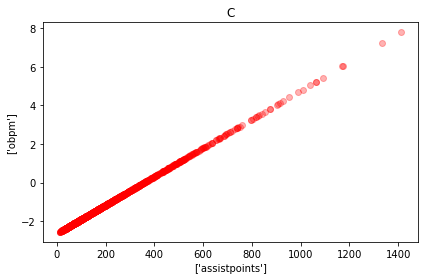

In [224]:
nVarLinRegbyPos(['assistpoints'], ['obpm'])

In [220]:
nba.groupby('pos').mean()

,season,age,g,gs,mp,per,ts%,3par,ftr,orb%,drb%,trb%,ast%,stl%,blk%,tov%,usg%,ows,dws,ws,ws/48,obpm,dbpm,bpm,vorp,fg,fga,fg%,3p,3pa,3p%,2p,2pa,2p%,efg%,ft,fta,ft%,orb,drb,trb,ast,stl,blk,tov,pf,pts,offposs,nonheavefg3pct,ftpoints,ptsassisted2s,ptsunassisted2s,ptsassisted3s,ptsunassisted3s,assisted2spct,nonputbacksassisted2spct,assisted3spct,shotqualityavg,ptsputbacks,fg2ablocked,fg2apctblocked,fg3ablocked,fg3apctblocked,assistpoints,twoptassists,threeptassists,atrimassists,shortmidrangeassists,longmidrangeassists,corner3assists,arc3assists,pointsprod/offposs,ows/offposs,obpm/offposs
pos,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C,2011.094434,26.76798,66.183865,40.279550,1604.231395,15.904565,0.552230,0.070226,0.356874,9.747029,21.061726,15.406504,8.529268,1.271482,3.329581,13.911069,18.274734,2.098812,2.146216,4.245779,0.119169,-1.122827,1.130206,0.003877,1.055660,256.819887,511.424640,0.504122,13.274547,39.053158,0.185825,243.545341,472.371482,0.516936,0.515827,124.395872,177.660413,0.687261,136.143840,303.846154,439.989994,89.407129,39.704816,68.010632,89.393371,167.585991,651.310194,3101.033146,0.151044,124.395247,315.442151,171.648530,38.388368,1.435272,0.664421,0.792573,0.405329,0.502252,70.411507,36.231395,0.081995,0.224515,0.015840,205.909944,62.307692,27.098186,34.560976,9.342089,18.404628,7.349593,19.748593,0.261436,0.000602,-0.000640
F,2011.073034,26.51030,65.804307,34.036517,1653.030899,14.051358,0.539423,0.262941,0.286611,5.869429,16.171582,11.016339,10.293820,1.552107,1.641713,12.386751,18.778886,1.862219,1.725609,3.588436,0.095406,-0.528090,0.120506,-0.405056,0.937500,259.180712,567.524345,0.453676,51.758427,145.221442,0.298365,207.422285,422.302903,0.488354,0.499934,126.091760,166.286049,0.739952,81.710674,236.203184,317.913858,113.241105,50.939607,33.258895,87.224719,143.622191,696.211610,3217.427434,0.288254,126.057584,241.295880,173.450375,141.005618,14.119382,0.606943,0.682767,0.778164,0.507514,38.668539,32.625468,0.082610,0.908240,0.008135,260.569757,78.771536,34.342228,44.023876,13.147940,21.599719,11.221910,23.120318,0.283930,0.000487,-0.000459
G,2011.674715,26.78169,65.104292,33.752850,1687.106304,13.694936,0.530304,0.344862,0.241910,2.522736,10.514118,6.515996,19.877934,1.790543,0.706606,13.565158,19.899497,1.853991,1.411536,3.265661,0.082547,0.058182,-0.792757,-0.734038,0.822401,262.457746,605.723340,0.426591,72.462441,199.882294,0.340586,189.995305,405.841046,0.463267,0.488239,125.601610,156.108987,0.788460,37.329645,157.076123,194.405433,218.360496,59.442656,14.686452,103.526492,124.456405,722.979544,3294.400402,0.346144,125.577465,148.079142,231.842388,172.194165,45.084507,0.422229,0.439550,0.801017,0.501232,11.626425,30.436284,0.079001,1.497988,0.008289,496.659289,158.147552,60.121395,84.878270,26.675721,46.593561,19.226023,40.895372,0.356750,0.000452,-0.000246


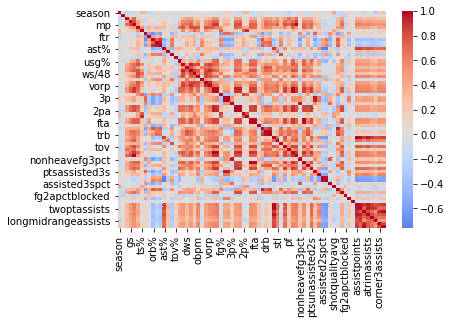

In [112]:
# All corr
sns.heatmap(nba.corr(), center=0, cmap='coolwarm')
plt.show()

## Data Description and Limitations